# Machine Learning using Pyspark
This notebook demonstrates machine learning using PySpark
<p id='content'></p> 

## Content

<ol>
    <li> <a href='#s1'> Dataset </a> </li>
    <li> <a href='#s2'> Interest of Study </a> </li>
    <li> <a href='#s3'> Data Schema </a> </li>
    <li> <a href='#s4'> Exploratory Data Analysis </a> </li>
    <li> <a href='#s5'> Data Wranggling and Feature Selection </a> </li>
    <li> <a href='#s6'> Modelling </a> </li>
    <li> <a href='#s7'> Model Selection, Diagnostics and Summary </a> </li>
    <li> <a href='#s8'> Model Evaluation </a> </li>
    <li> <a href='#s9'> Interpretation and Discussion </a> </li>
    <li> <a href='#s10'> A Heuristic Application </a> </li>
</ol>

<p id='s1'></p>

## 1. Dataset  
The Kaggle **Body Fat dataset** is selected for the study (www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset). The dataset is first downloaded from Kaggle, then uploaded to the Hadoop FS directory.

According to the documentation, the dataset collects measurements of 252 men including Age, Weight in lb, Height in inches, and circumferences of 10 different body parts in cm including Neck, Chest, Abdomen, Hip, Thigh, Knee, Ankle, Biceps (extended), Forearm and Wrist.  Denote these 13 features as biomarkers.  The BodyFat, presented as percentages, is the response of interest.  It is *calculated* from body density in g/cm$^3$ determined by underwater weighing.  Both BodyFat and Density are recorded in the dataset.  All the features and response are continuous.  The dataset is of shape  252 x 15 (13 biomarkers+Density+BodyFat).

<a href='#content'>Top</a>
<p id='s2'></p>

## 2. Interest of Study 
**Regression study** on the significance of the 13 biomarkers in association with the body fat in men.  This may help estimate body fat of men when underwater weighing is not handy.

Common libraries for data science including PySpark are loaded.  A spark session is created.

In [1]:
import pyspark
import numpy as np; import pandas as pd
import matplotlib.pyplot as plt

# load a couple of pyspark libraries
from pyspark.ml.feature import VectorAssembler as VA
from pyspark.ml.feature import StandardScaler as SS
from pyspark.ml.regression import LinearRegression as LR
from pyspark.ml.evaluation import RegressionEvaluator as RE

In [2]:
sc = pyspark.SparkContext(appName='BodyFat')
spark = pyspark.sql.SparkSession.builder.appName('BodyFat').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/27 07:00:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/27 07:00:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/09/27 07:00:26 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/09/27 07:00:26 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/09/27 07:00:26 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


<a href='#content'>Top</a>
<p id='s3'></p>

## 3. Data Schema
As a start, the schema of the data is checked to get some look and feel.

In [3]:
#!hadoop fs -put bodyfat.csv <directory>
df = spark.read.csv('<directory>/bodyfat.csv', inferSchema=True, header=True)
df.count()

252

In [4]:
df.printSchema()

root
 |-- Density: double (nullable = true)
 |-- BodyFat: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Weight: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Neck: double (nullable = true)
 |-- Chest: double (nullable = true)
 |-- Abdomen: double (nullable = true)
 |-- Hip: double (nullable = true)
 |-- Thigh: double (nullable = true)
 |-- Knee: double (nullable = true)
 |-- Ankle: double (nullable = true)
 |-- Biceps: double (nullable = true)
 |-- Forearm: double (nullable = true)
 |-- Wrist: double (nullable = true)



In [5]:
# drop density
df = df.drop('Density')
df.show(3)

+-------+---+------+------+----+-----+-------+----+-----+----+-----+------+-------+-----+
|BodyFat|Age|Weight|Height|Neck|Chest|Abdomen| Hip|Thigh|Knee|Ankle|Biceps|Forearm|Wrist|
+-------+---+------+------+----+-----+-------+----+-----+----+-----+------+-------+-----+
|   12.3| 23|154.25| 67.75|36.2| 93.1|   85.2|94.5| 59.0|37.3| 21.9|  32.0|   27.4| 17.1|
|    6.1| 22|173.25| 72.25|38.5| 93.6|   83.0|98.7| 58.7|37.3| 23.4|  30.5|   28.9| 18.2|
|   25.3| 22| 154.0| 66.25|34.0| 95.8|   87.9|99.2| 59.6|38.9| 24.0|  28.8|   25.2| 16.6|
+-------+---+------+------+----+-----+-------+----+-----+----+-----+------+-------+-----+
only showing top 3 rows



<a href='#content'>Top</a>
<p id='s4'></p>

## 4. Exploratory Data Analysis
The Density column is first dropped because it *derives* the response BodyFat. The dataset is checked with no missing values [4(a)] but may contain outliers.  For example, there are some doubtful records such as BodyFat being 0% and 0.7%, as well as Height being 29.5 inches [4(b)].  **Boxplot** is used to visualise outliers outside the interquartile ranges, say, two data points for Ankle circumference greater than 30cm and one data point for Weight greater than 300 lbs.  After **filtering out these 6 outliers**, the boxplot shows that the remaining 246 data points only have minor outliers which are considered fair for further analysis [4(c)].

### 4(a) Count NA values

In [6]:
na_count = sc.accumulator(0) # use spark accumulator
cols = df.columns

for col in cols:
    na_count += df.filter(df[col].isNull()).count()
print('NA values in the dataset:', na_count) # 0

NA values in the dataset: 0


### 4(b) Summary of dataset

In [7]:
df.describe(cols[:7]).show(truncate=8)

+-------+--------+--------+--------+--------+--------+--------+--------+
|summary| BodyFat|     Age|  Weight|  Height|    Neck|   Chest| Abdomen|
+-------+--------+--------+--------+--------+--------+--------+--------+
|  count|     252|     252|     252|     252|     252|     252|     252|
|   mean|19.15...|44.88...|178.9...|70.14...|37.99...|100.8...|92.55...|
| stddev|8.368...|12.60...|29.38...|3.662...|2.430...|8.430...|10.78...|
|    min|     0.0|      22|   118.5|    29.5|    31.1|    79.3|    69.4|
|    max|    47.5|      81|  363.15|   77.75|    51.2|   136.2|   148.1|
+-------+--------+--------+--------+--------+--------+--------+--------+



In [8]:
df.describe(cols[7:]).show(truncate=8)

+-------+--------+--------+--------+--------+--------+--------+--------+
|summary|     Hip|   Thigh|    Knee|   Ankle|  Biceps| Forearm|   Wrist|
+-------+--------+--------+--------+--------+--------+--------+--------+
|  count|     252|     252|     252|     252|     252|     252|     252|
|   mean|99.90...|59.40...|38.59...|23.10...|32.27...|28.66...|18.22...|
| stddev|7.164...|5.249...|2.411...|1.694...|3.021...|2.020...|0.933...|
|    min|    85.0|    47.2|    33.0|    19.1|    24.8|    21.0|    15.8|
|    max|   147.7|    87.3|    49.1|    33.9|    45.0|    34.9|    21.4|
+-------+--------+--------+--------+--------+--------+--------+--------+



In [9]:
# Ascending Height to check irregularities
# take 15 corresponds to lowest 15/252 ~ 6% of data
np.array(df.select('Height').sort('Height').take(15)).flatten()

array([29.5 , 64.  , 64.  , 64.75, 65.  , 65.5 , 65.5 , 65.75, 65.75,
       65.75, 65.75, 65.75, 65.75, 66.  , 66.  ])

In [10]:
# Ascending BodyFat to check irregularities
np.array(df.select('BodyFat').sort('BodyFat').take(15)).flatten()

array([0. , 0.7, 3. , 3.7, 3.7, 3.9, 4. , 4.1, 5.2, 5.3, 5.6, 5.7, 6. ,
       6.1, 6.3])

### 4(c) Boxplots to visualise outliers

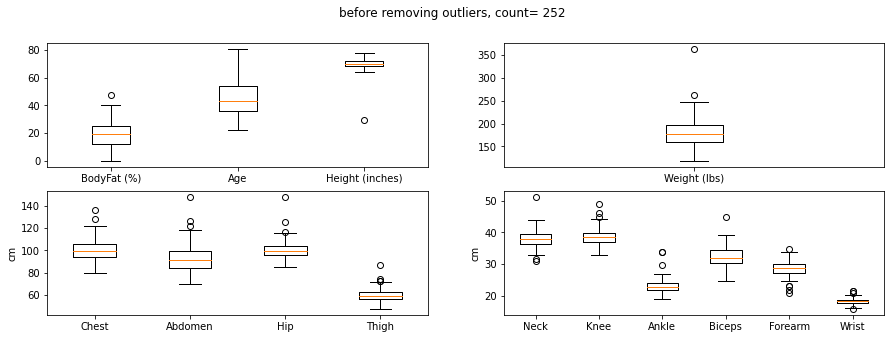

In [11]:
# conversion to local pandas dataframe is for visualisation purpose only
# it is manageable to use local storage for small dataset

df_pd = df.toPandas()

def outlier_boxplot(df_in, des): # a dataframe with description
    df_in = df_in.copy()
    fig, ax = plt.subplots(2,2, figsize=(15,5))

    plt.suptitle(des + ', count= %d' %df_in.shape[0])
    # BodyFat, Age and Height in similar range
    ax[0][0].boxplot(df_in[[cols[0], cols[1], cols[3]]])
    ax[0][0].set_xticklabels(['BodyFat (%)','Age', 'Height (inches)'])

    # Weight
    ax[0][1].boxplot(df_in[cols[2]])
    ax[0][1].set_xticklabels(['Weight (lbs)'])

    # Larger measurements Chest, Abdomen, Hip, Thigh
    ax[1][0].boxplot(df_in[cols[5:9]])
    ax[1][0].set_xticklabels(cols[5:9])
    ax[1][0].set_ylabel('cm')

    # Smaller measurements Neck, Knee, Ankle, Biceps, Forearm, Wrist
    ax[1][1].boxplot(df_in[[cols[4]]+cols[9:]])
    ax[1][1].set_xticklabels([cols[4]]+cols[9:]) #for single boxplot
    ax[1][1].set_ylabel('cm')

    plt.show()

outlier_boxplot(df_pd,'before removing outliers')

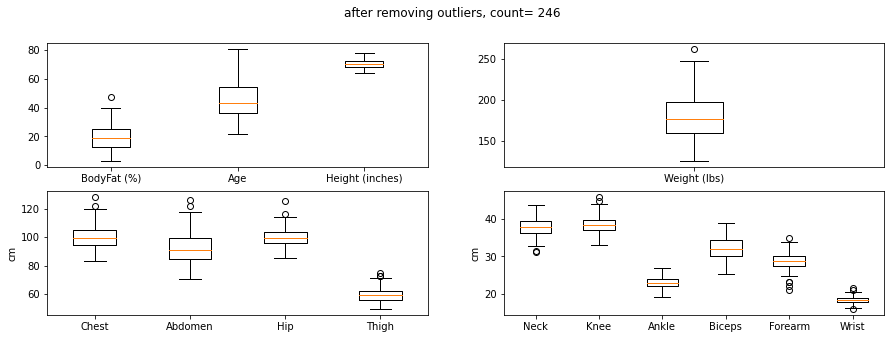

In [12]:
# filter outliers identified in previous analysis
df_fil = df.filter((df['BodyFat'] > 0.7) & (df['Height'] > 50) \
                   & (df['Ankle'] < 30) & (df['Weight'] < 300))
df_fil_pd = df_fil.toPandas()   
outlier_boxplot(df_fil_pd, 'after removing outliers')

### 4(d) Individual Plots
Initial plots suggest *individually* each biomarker has positive association with BodyFat.  There is **no apparent non-linear dependence between the response and features**, the relationships are close to linear.  This supports non-linear transformations on the features e.g. powers or logs could be saved.  It must be emphasised that the biomarker does not necessarily have positive and/or significant association with BodyFat when modelled with other biomarkers.

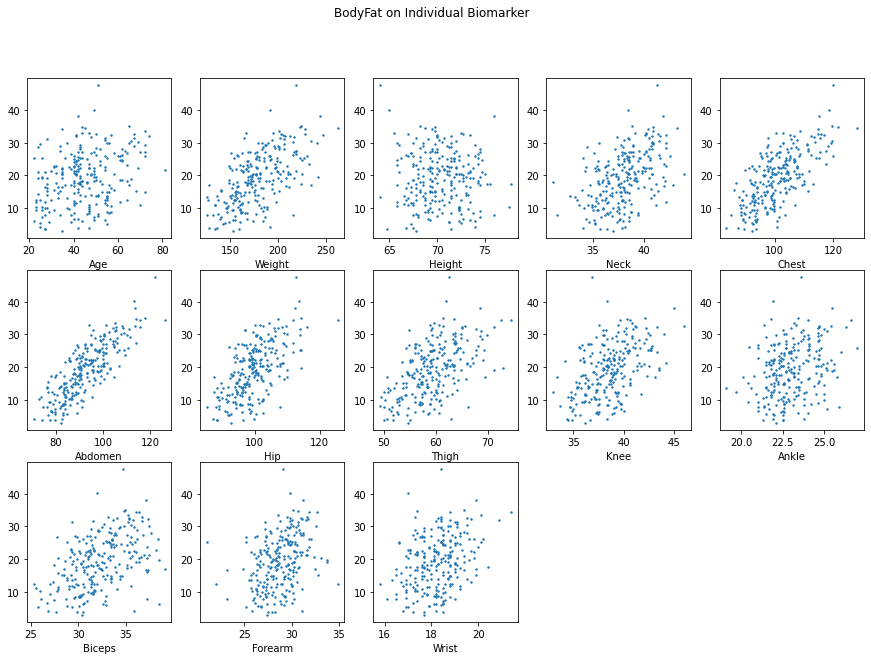

In [13]:
# plot of BodyFat against each biomarker
fig, ax = plt.subplots(3,5, figsize=(15,10))
ax = ax.flatten()

for idx, col in enumerate(cols[1:]):
    ax[idx].scatter(df_fil_pd[col], df_fil_pd['BodyFat'], s=2)
    ax[idx].set_xlabel(col)
    
ax[13].axis('off'); ax[14].axis('off')
plt.suptitle('BodyFat on Individual Biomarker')
plt.show()

### 4(e) Feature Correlations
The **correlation matrix** indicates certain **strong correlations between features**, especially Weight has rather high correlation with most other features.  A more systematic analysis is performed in the Data Wranggling and Feature Selection section.

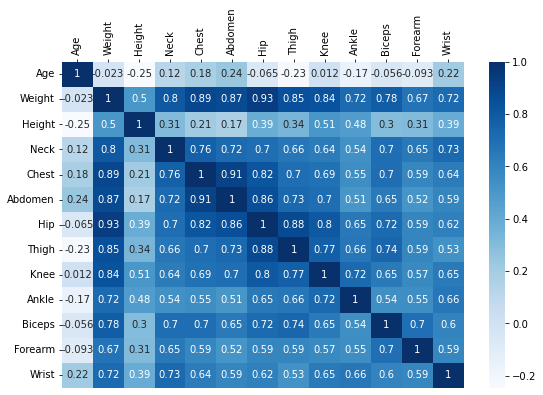

In [14]:
from pyspark.ml.stat import Correlation
import seaborn as sns

# compute correlation matrix and plot using seaborn's heatmap
va = VA(inputCols=cols[1:], outputCol='features')
df_fil_cor = va.transform(df_fil)
corr_mtx = Correlation.corr(df_fil_cor, 'features', 'pearson').collect()[0][0]

fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr_mtx.toArray(), annot=True, cmap='Blues', \
            xticklabels=cols[1:], yticklabels=cols[1:])
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(rotation='vertical')

plt.show()

<a href='#content'>Top</a>
<p id='s5'></p>

## 5. Data Wranggling and Feature Selection
The aforesaid 6 outliers identified in EDA are removed from the dataset. A **train-test split** of 70:30 gives training/test data sizes 174 and 72 respectively.

In [15]:
# train-test split
df_train, df_test = df_fil.randomSplit([0.7, 0.3], seed=0)
print('train set count:', df_train.count(), \
      'test set count:', df_test.count())

train set count: 174 test set count: 72


### 5(a) Variance Inflation Factors (VIF)
An analysis on the VIF is performed using the training set in order to avoid 'information leakage' from test data.  The VIF calculates how much a feature can be explained by others through linear regression.  A common threshold is 5 or 10 <a href=#ref1>[1]</a>.   The data has VIF for Weight is about 41.8, which far exceeds the threshold.  After removing Weight, there are no features whose VIF exceeds 10.

<p id='ref1'></p>
[1] Gareth James et al "An Introduction to Statistical Learning with Applications in R (2nd Edition)", Springer, 2nd Edition, Chapter 3.3.3.6

In [16]:
# calculate VIF

def calvif(vif_dict, feature_col):
    # iterate over the features and perform LR 
    # on one feature against others
    for col in feature_col:
        fcol_ = feature_col.copy()
        fcol_.remove(col)
        va_ = VA(inputCols=fcol_, outputCol='features')
        df_vif_ = va_.transform(df_train)
        
        # an arbitrary small regParam is set to skip the warning messages
        # without affecting the regression results
        lr_vif_ = LR(featuresCol='features', labelCol=col, regParam = 1e-12)
        model_vif_ = lr_vif_.fit(df_vif_)
        
        # calculate VIF using 1/(1-R_col^2)
        vif_dict[col] = 1/(1-model_vif_.summary.r2)

# all features including Weight
vif = {}
feature_col = cols[1:].copy()
calvif(vif, feature_col)

# save result
vif_pd = pd.DataFrame(vif.values(), index=vif.keys(), columns=['VIF'])\
  .sort_values('VIF', ascending=False).T

In [17]:
vif_pd.iloc[:,0:7]

,Weight,Hip,Abdomen,Chest,Thigh,Knee,Neck
VIF,41.750859,11.814695,10.895483,9.087333,6.444677,4.280428,3.712001


In [18]:
vif_pd.iloc[:,7:]

,Height,Wrist,Biceps,Ankle,Forearm,Age
VIF,3.355202,3.288581,3.080229,2.993099,2.322044,2.198885


In [19]:
# VIFs with Weight removed
vif2 = {}
feature_col = cols[1:].copy()
feature_col.remove('Weight')
calvif(vif2, feature_col)
# save result
vif_pd2 = pd.DataFrame(vif2.values(), index=vif2.keys(), columns=['VIF'])\
  .sort_values('VIF', ascending=False).T

In [20]:
vif_pd2.iloc[:,0:7]

,Hip,Abdomen,Chest,Thigh,Knee,Neck,Wrist
VIF,9.740636,9.088349,6.771034,6.316341,4.21307,3.39414,3.163677


In [21]:
vif_pd2.iloc[:,7:]

,Biceps,Ankle,Forearm,Age,Height
VIF,2.929988,2.886339,2.289553,2.069797,1.836834


### 5(b) Effect due to Feature Selection

A simple linear regression model is used to estimate the effect.  The training error, meausred in adjusted R$^2$ score, slightly improves (reduces) with the (multi-)collinear feature Weight removed.

In [22]:
# Model comparision by adjusted R2 score
def LR_train(feature_col):
    va_ = VA(inputCols=feature_col, outputCol='features')
    lr_ = LR(featuresCol='features', labelCol='BodyFat', regParam=1e-12)
    df_ = va_.transform(df_train)
    lr_model_ = lr_.fit(df_)
    return lr_model_.summary.r2adj

lr_train_err = {}

feature_col = cols[1:].copy() # all features
lr_train_err['all features'] = LR_train(feature_col)

feature_col.remove('Weight') # remove Weight
lr_train_err['Weight removed'] = LR_train(feature_col)

print('Training error in adjusted R^2 score:')
lr_train_err

Training error in adjusted R^2 score:


{'all features': 0.7483591387035834, 'Weight removed': 0.7498506622374421}

<a href='#content'>Top</a>
<p id='s6'></p>

## 6. Modelling
To recap the features to be used

In [23]:
print(feature_col)

['Age', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']


A couple of regression models are be explored:
- **Simple Linear Regression**
- **ElasticNet** i.e. linear combination of Lasso and Ridge Regression
- **Generalised Linear Model**
- **Decision Tree Regression**

To maintain equal footing of features in the models, the train / test data are first standardised.  The BodyFat in percentage is also transformed into decimals.

In [24]:
from pyspark.ml import Pipeline
va_ss = VA(inputCols=feature_col, outputCol='features')  # vector assembler
ss = SS(inputCol='features', outputCol='features_ss', 
        withMean=True, withStd=True)                     # standard scaler
pipeline = Pipeline(stages=[va_ss, ss])                  # pipeline

In [25]:
# standardise train / test set
df_train_ss = pipeline.fit(df_train).transform(df_train)
df_test_ss = pipeline.fit(df_test).transform(df_test)

# convert BodyFat to decimals
df_train_ss = df_train_ss.withColumnRenamed('BodyFat', 'BodyFat%')
df_train_ss = df_train_ss.withColumn('BodyFat', df_train_ss['BodyFat%']/100)

df_test_ss = df_test_ss.withColumnRenamed('BodyFat', 'BodyFat%')
df_test_ss = df_test_ss.withColumn('BodyFat', df_test_ss['BodyFat%']/100)

To evaluate the training error and actual test error, a evaluation function is defined to calculate the RMSE of the predicted BodyFat and the adjusted R$^2$ of a model.

In [26]:
def model_eval(model, eval_set):
    
    # get prediction
    pred = model.transform(eval_set)
    
    n = eval_set.count()
    p = len(feature_col)
    
    # compute metrics using RMSE and R2
    rmse = RE(predictionCol='prediction', labelCol='BodyFat', metricName='rmse')
    r2 = RE(predictionCol='prediction', labelCol='BodyFat', metricName='r2')
    
    # calculate adjusted R2
    rmse = rmse.evaluate(pred)
    r2adj = 1-(1-r2.evaluate(pred))*(n-1)/(n-p-1)
    
    print('RMSE:', rmse)
    print('Adjusted R^2:', r2adj)
    
    return [rmse, r2adj]

In [27]:
# to store model train rmse for comparison
train_rmse = {}

### 6(a) Simple Linear Regression

Here regParam is set to be zero (default value).  The adjusted R$^2$ score is almost the same as that obtained in the VIF analysis above.  It is invariant because of the linearity of the model.  The RMSE and regression coefficients are, however, subject to the scaling.

In [28]:
# Simple Linear Regression Model
lr = LR(featuresCol='features_ss', labelCol='BodyFat')
lr_model = lr.fit(df_train_ss)

print('LR train')
train_rmse['LR'] = model_eval(lr_model, df_train_ss)

23/09/27 07:01:06 WARN Instrumentation: [9bebc3f3] regParam is zero, which might cause numerical instability and overfitting.
LR train
RMSE: 0.038631858659956025
Adjusted R^2: 0.7498506622374416


### 6(b) ElasticNet and CrossValidation
The ElasticNet is the linear combination of Lasso regression and Ridge regression.  The hyperparameter space is explored through grid search of the ElasticNet parameter and the regularisation parameter.  According to PySpark documentation, elasticNetParam is 1 for (pure) Lasso and 0 for (pure) Ridge.  A **five-fold Cross-validation** (CV) on train set is used to find the hyperparameters with yielding lowest CV error.

In [29]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

estimator = LR(featuresCol='features_ss', labelCol='BodyFat')
grid = ParamGridBuilder().addGrid(estimator.regParam, [1e-4, 0.001, 0.01, 0.1, 1, 10]) \
                         .addGrid(estimator.elasticNetParam, [0, 0.5, 1]).build()
evaluator = RE(predictionCol='prediction', labelCol='BodyFat', metricName='rmse')

cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(df_train_ss)

In [30]:
best_reg = cvModel.bestModel.getRegParam()
best_en = cvModel.bestModel.getElasticNetParam()
print(best_reg, best_en)

0.001 1.0


Based on the CV result, a Lasso regression with regularisation parameter 0.001 is the best model of ElasticNet.

In [31]:
lasso = LR(featuresCol='features_ss', labelCol='BodyFat', regParam=best_reg, elasticNetParam=best_en)
lasso_model = lasso.fit(df_train_ss)

print('Lasso train')
train_rmse['Lasso'] = model_eval(lasso_model, df_train_ss)

Lasso train
RMSE: 0.039078033715678945
Adjusted R^2: 0.7440391421324497


### 6(c) Generalised Linear Model
A Generalised Linear Model (GLM) of **Gamma family and log link** function is used.  The linear regression above is the case using Gaussian family with identity link.

In [32]:
from pyspark.ml.regression import GeneralizedLinearRegression as GLM
glm_gamma = GLM(family='gamma', link='log', regParam=1e-12,
                featuresCol='features_ss', labelCol='BodyFat')
glm_gamma_model = glm_gamma.fit(df_train_ss)

print('GLM Gamma train')
train_rmse['Gamma'] = model_eval(glm_gamma_model, df_train_ss)

GLM Gamma train
RMSE: 0.04313084416037503
Adjusted R^2: 0.6881942877924532


Though not legitimate, let's try to convince (confuse) ourselves that BodyFat percentage is a measure of probability that the body is made up of fat.  A GLM using **Binomial family with logit link** function is tested out.  This is also one of the considerations to convert the responses BodyFat into decimals.

In [33]:
glm_bino = GLM(family='binomial', link='logit', regParam=1e-12,
               featuresCol='features_ss', labelCol='BodyFat')
glm_bino_model = glm_bino.fit(df_train_ss)

print('GLM Binomial train')
train_rmse['Binomial'] = model_eval(glm_bino_model, df_train_ss)

GLM Binomial train
RMSE: 0.03973350839520098
Adjusted R^2: 0.735380418145825


### 6(d) Decision Tree Regression
**Non-parametric models** are explored.  **Decision trees** are easily overfitted.  It is reasonable to CV the tree depth for at most half the number of variables.  It turns out othat the best maximum depth is 2 Decision Tree Regression.

In [34]:
from pyspark.ml.regression import DecisionTreeRegressor as DTR

In [35]:
# CV on maximum depth of the decision tree
estimator = DTR(featuresCol='features_ss', labelCol='BodyFat')
grid = ParamGridBuilder().addGrid(estimator.maxDepth, np.arange(6)).build()
evaluator = RE(predictionCol='prediction', labelCol='BodyFat', metricName='rmse')

cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, 
                    evaluator=evaluator, numFolds=5)
cvModel = cv.fit(df_train_ss)

In [36]:
cvModel.bestModel.getMaxDepth()

2

In [37]:
dtr = DTR(featuresCol='features_ss', labelCol='BodyFat', maxDepth=2)
dtr_model = dtr.fit(df_train_ss)

print('DT Regression train')
train_rmse['DT'] = model_eval(dtr_model, df_train_ss)

DT Regression train
RMSE: 0.049146016514987415
Adjusted R^2: 0.5951587146417627


Let's go further to deploy **Random Forest Regression** with bootstrap.  Maximum depth is chosen to be 2 from previous experience.  CV finds that the best number of trees is 400.

In [38]:
from pyspark.ml.regression import RandomForestRegressor as RFR

In [39]:
# CV on numTrees from 100 to 500 on an interval of 50
estimator = RFR(featuresCol='features_ss', labelCol='BodyFat', 
                bootstrap=True, maxDepth=2, seed=123)
grid = ParamGridBuilder().addGrid(estimator.numTrees, np.arange(100,501,50)).build()
evaluator = RE(predictionCol='prediction', labelCol='BodyFat', metricName='rmse')

cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, 
                    evaluator=evaluator, numFolds=5)
cvModel = cv.fit(df_train_ss)

In [40]:
cvModel.bestModel.getNumTrees

250

In [41]:
rfr = RFR(featuresCol='features_ss', labelCol='BodyFat', 
          bootstrap=True, maxDepth=2, numTrees=400, seed=123)
rfr_model = rfr.fit(df_train_ss)

print('RF Regression train')
train_rmse['RF'] = model_eval(rfr_model, df_train_ss)

RF Regression train
RMSE: 0.05001905649030885
Adjusted R^2: 0.5806475918724885


<a href='#content'>Top</a>
<p id='s7'></p>

## 7. Model Selection, Diagnostics and Summary
### 7(a) Model Selection
The training errors of the models in terms of RMSE and adjusted R$^2$ scores are compared.  Despite being simple, the **Linear Regression Model** yields the lowest RMSE and higest adjusted R$^2$ scores in the training and is therefore selected.

In [42]:
pd.DataFrame(train_rmse, index=['Train RMSE', 'Train R2'])

,LR,Lasso,Gamma,Binomial,DT,RF
Train RMSE,0.038632,0.039078,0.043131,0.039734,0.049146,0.050019
Train R2,0.749851,0.744039,0.688194,0.735380,0.595159,0.580648


Here the original format of the train / test data are used i.e. without standardisation of features and responses remain as percentages.  The interpretation just goes from "change of decimal BodyFat per unit change of a standard deviation of a biomarker" to "change of BodyFat percentage per unit change of a biomarker", which may help understanding of some audience.  Due to linearity of the model, the train RMSE would change (to be specific 100 times as represented in percentages), so would the magnitudes of the regression coefficients.  On the contrary, the adjused R$^2$ and feature importance (in terms of sign and p-values) would not change.

In [43]:
# evaluate performance of LR model using original magnitudes
va2 = VA(inputCols=feature_col, outputCol='features')
df_train2 = va2.transform(df_train)
df_test2 = va2.transform(df_test)

lr2 = LR(featuresCol='features', labelCol='BodyFat')
lr_model2 = lr2.fit(df_train2)

model_eval(lr_model2, df_train2);

23/09/27 07:02:33 WARN Instrumentation: [0a94dbf5] regParam is zero, which might cause numerical instability and overfitting.
RMSE: 3.8631858659956033
Adjusted R^2: 0.7498506622374419


### 7(b) Diagnostic Plots
In R, there is a handy function plot(linear_model) to diagnose the model.  A replica in Python is reproduced as follows.  The left panel is residuals vs fitted values, there is no apparent pattern.  If there is, there should be unmodelled relationship between the response and the features.  The middle panel is the scale-location plot which shows constant variance across the fitted value i.e. the constant variance assumption of the linear regression model is satisfied.  The last one is the QQ-plot which the central portion generally fits onto a straight line with slope one - it is evident that the normal assumption of the model is satisfied and model summary can be discussed.

In [44]:
from pyspark.sql import functions as func

In [45]:
def diagnostic_plot(model): # takes a fitted model as argument
    
    # it happens that LR is the best model so the PySpark functions can be exploited
    # otherwise the predictions and residuals may need to be computed out
    df_fit = model.summary.predictions
    res = model.summary.residuals
    
    # standardise predictions, StandardScaler can also be used
    pred_mean = df_fit.agg(func.mean('prediction')).collect()[0][0]
    pred_sd = df_fit.agg(func.stddev('prediction')).collect()[0][0]
    df_fit = df_fit.withColumn('pred_s', (df_fit['prediction']-pred_mean)/pred_sd)
    
    # standardise residuals 
    res_mean = res.agg(func.mean('residuals')).collect()[0][0]
    res_sd = res.agg(func.stddev('residuals')).collect()[0][0]
    res = res.withColumn('res_s', (res['residuals']-res_mean)/res_sd)
        
    # square root of standardised residuals
    res = res.withColumn('abs_sq_res_s', func.sqrt(func.abs(res['res_s'])))
    
    # collect only necessary columns
    df_fit_pd = df_fit.select('prediction','pred_s').toPandas()
    res_pd = res.select('residuals','res_s','abs_sq_res_s').toPandas()
    
    # replica of R plot(linear_model)
    fig, ax = plt.subplots(1,3, figsize=(15,3))
    ax = ax.flatten()

    # subplot1 - residuals vs fitted values
    ax[0].scatter(df_fit_pd['prediction'], res_pd['residuals'], s=6)
    ax[0].axhline(0, ls='dotted', color='black')
    ax[0].set_xlabel('fitted values')
    ax[0].set_ylabel('residuals')

    # subplot2 - sqrt|standardised residuals| vs fitted values
    ax[1].scatter(df_fit_pd['prediction'], res_pd['abs_sq_res_s'], s=6)
    ax[1].set_xlabel('fitted values')
    ax[1].set_ylabel('sqrt |standardised residuals|')

    # subplot3 - QQ-plot: standardised residuals vs fitted values 
    ax[2].scatter(np.sort(df_fit_pd['pred_s']), np.sort(res_pd['res_s']), s=6)
    ax[2].plot([-3,3],[-3,3], ls='dotted', color='black')
    ax[2].set_xlabel('theoretical quantiles')
    ax[2].set_ylabel('standardised residuals')

    plt.show()

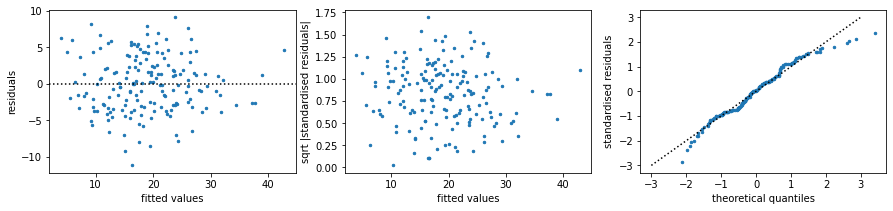

In [46]:
diagnostic_plot(lr_model2)

### 7(c) Model Summary
The LR model can be easily interpreted through the coefficients.  To recap, the RMSE is about 3.8632 (% as unit).  The adjusted R$^2$ is about 0.7499 i.e. the model could explain about 75% variance of the *training* data.

In [47]:
model_eval(lr_model2, df_train2);

RMSE: 3.8631858659956033
Adjusted R^2: 0.7498506622374419


**Regresion Coefficients**  
The regression coefficients and relevant statistics in descending p-values are reported below.  The p-value of 'Abdomen' is very close to zero.  The regression coefficient of 0.9 means, keeping other features constant, on average, a unit change of Abdomen (measured in cm) is positively associated with 0.9% increase in BodyFat.  The low p-values (<0.05) suggests this association is statistically significant.  The strength of the association 0.9 falls into a 95% confidence interval of (0.715, 1.092).

In [48]:
# obtain coefficients, p-values, standard errors, and t-values
# PySpark summary orders the values in features then intercept
coef = lr_model2.coefficients.tolist() + [lr_model2.intercept]
pval = lr_model2.summary.pValues
se = lr_model2.summary.coefficientStandardErrors
tval = lr_model2.summary.tValues

In [49]:
# sort by p-values
train_result = pd.DataFrame(index=feature_col+['intercept'], \
                            data={'Coef':coef, 'pVal':pval, \
                                  'tval':tval, 'SE': se})
train_result['CI low'] = train_result['Coef']-2*train_result['SE']
train_result['CI high'] = train_result['Coef']+2*train_result['SE']

train_result = train_result.sort_values('pVal').T

In [50]:
# 7 most significant features
train_result.iloc[:,:7]

,Abdomen,Wrist,Age,Chest,Forearm,Height,Thigh
Coef,0.903424,-2.497925,0.080304,-0.163496,0.264169,-0.177597,0.164957
pVal,0.000000,0.000077,0.027753,0.104628,0.245794,0.269927,0.333912
tval,9.593155,-4.057890,2.220899,-1.632027,1.164871,-1.107042,0.969174
SE,0.094174,0.615572,0.036158,0.100180,0.226780,0.160425,0.170204
CI low,0.715076,-3.729070,0.007987,-0.363856,-0.189390,-0.498448,-0.175450
CI high,1.091771,-1.266780,0.152621,0.036863,0.717728,0.143253,0.505365


In [51]:
# least significant features
train_result.iloc[:,7:]

,Neck,intercept,Hip,Ankle,Knee,Biceps
Coef,-0.219424,8.080830,-0.089178,-0.093363,0.025464,-0.010244
pVal,0.377354,0.412859,0.565234,0.820434,0.929815,0.956384
tval,-0.885227,0.821002,-0.576276,-0.227358,0.088216,-0.054777
SE,0.247874,9.842646,0.154749,0.410641,0.288657,0.187012
CI low,-0.715171,-11.604462,-0.398675,-0.914645,-0.551849,-0.384268
CI high,0.276323,27.766122,0.220319,0.727920,0.602778,0.363780


<a href='#content'>Top</a>
<p id='s8'></p>

## 8. Model Evaluation

The test set, not being exposed in the training stage, is used to evaluate the selected LR model.  The metrics are computed:

In [52]:
model_eval(lr_model2, df_test2);

RMSE: 4.814293453362716
Adjusted R^2: 0.6069762923947721


The RMSE of test data is about 4.8143 (% as unit), slightly larger than training error as expected.  The adjusted R$^2$ score is about 0.6070, smaller than training value also as expected.  The model could explain about 60.7% of the variance of the test data.

<a href='#content'>Top</a>
<p id='s9'></p>

## 9. Interpretation and Discussion
Among Linear Regression models (including regularised elasticNet and Generalised Linear Models) as non-parametric models (Decision Tree Regression and Random Forest Regression), the **simple Linear Regression model performs the best in the training error and is selected**.  

From Model Diagnostic, the Linear Regression model **fairly captures the relationships between the features and the response** BodyFat.  From Model Summary, the model is able to explain about 75% variance of the training data and 61% variance of the test data.  The RMSEs for training / test data are 3.86 / 4.81, which roughly translate to an average error of 3.86 (% as unit) and 4.81 (% as unit) on predictions of BodyFat percentages.

There are **three statistically signficant biomarkers identified**: keeping other features unchanged, on average, the BodyFat (i) increases by about 0.9% per each cm increase in Abdomen measurement; (ii) decreases by about 2.5% per each cm increase in Wrist measurement; and (iii) increases by 0.08% per each year increment on Age.  The other biomarkers are not statistically significant, and Weight is discarded in the analysis as it correlates much with other features.

<a href='#content'>Top</a>
<p id='s10'></p>

## 10. A Heuristic Application

The model is applied to estimate the BodyFat of Bruce Lee <a href='#ref23'>[2]</a>.  It is not possible to weigh him underwater to estimate his density but some of his body measurements are available upon Google search <a href='#ref23'>[3]</a>.  For other missing values, the average values of the wranggled dataset are heuristically adopted.  The model predicts his BodyFat at about 8.4%. 

From <a href='#ref23'>[3]</a>, Bruce Lee has the following body measurement:  
Height: 5'7 1/4" (67.25 inches)  
Weight: 141 pounds (not used in the model)  
Chest: 40 inches (101.6 cm)  
Waist: 32 inches (81.28 cm, assumed to be Abdomen)  
Biceps: 15 inches (38.1 cm)  

No other measurements found i.e. missing values.  It may not be justified, but average values of the BodyFat dataset is adopted.

Mr Lee passed away at age 32.  The age attribute is just assumed to be 30.

In [53]:
web = {'Age':30, 'Height':67.25, 'Chest': 101.6, 'Abdomen':81.28, 'Biceps':38.1}
bruce_col = cols[1:].copy()
bruce_col.remove('Weight')
bruce = {}

# use known values otherwise use mean from dataset
for col in bruce_col:
    if col in web.keys():
        bruce[col] = web[col]
    else:
        bruce[col] = df_fil.select(func.mean(col)).collect()[0][0]
bruce

{'Age': 30,
 'Height': 67.25,
 'Neck': 37.98048780487802,
 'Chest': 101.6,
 'Abdomen': 81.28,
 'Hip': 99.76666666666662,
 'Thigh': 59.361788617886155,
 'Knee': 38.5707317073171,
 'Ankle': 23.0028455284553,
 'Biceps': 38.1,
 'Forearm': 28.697967479674794,
 'Wrist': 18.232113821138213}

In [54]:
# create dataframe
rdd = sc.parallelize([bruce])
bruce_df = spark.createDataFrame(rdd)

In [55]:
# predict
bruce_df = va2.transform(bruce_df)
bruce_df = lr_model2.transform(bruce_df)
bruce_df.select('prediction').show()

+-----------------+
|       prediction|
+-----------------+
|8.409868141084742|
+-----------------+



<p id='ref23'></p>  

[2] https://en.wikipedia.org/wiki/Bruce_Lee  
[3] https://celebrityinside.com/body-measurements/actor/bruce-lee-height-weight-shoe-size-facts-family-bio/

<a href='#content'>Top</a>